Sentiment Analysis on Rotten Tomatoes Reviews

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  rotten_tomatoes_link      critic_name  top_critic           publisher_name  \
0            m/0814255  Andrew L. Urban       False           Urban Cinefile   
1            m/0814255    Louise Keller       False           Urban Cinefile   
2            m/0814255              NaN       False      FILMINK (Australia)   
3            m/0814255     Ben McEachen       False  Sunday Mail (Australia)   
4            m/0814255      Ethan Alter        True       Hollywood Reporter   

  review_type review_score review_date  \
0       Fresh          NaN  2010-02-06   
1       Fresh          NaN  2010-02-06   
2       Fresh          NaN  2010-02-09   
3       Fresh        3.5/5  2010-02-09   
4      Rotten          NaN  2010-02-10   

                                      review_content  
0  A fantasy adventure that fuses Greek mythology...  
1  Uma Thurman as Medusa, t

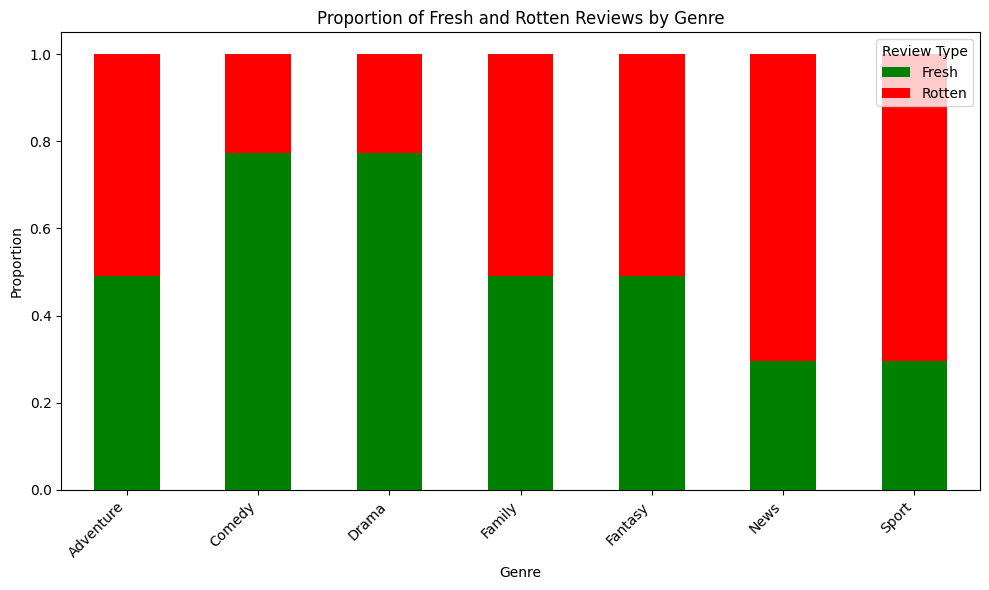

In [4]:
# Mount Google Drive to access your files
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Define the file paths
ratings_path = '/content/drive/MyDrive/title.ratings.tsv.gz'
basics_path = '/content/drive/MyDrive/title.basics.tsv.gz'
zip_path = '/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv.zip'

# Step 1: Read title.ratings.tsv and title.basics.tsv files in chunks to avoid memory overload
chunksize = 10000  # Reduce the chunk size for memory optimization

# Reading in the ratings data in chunks
ratings_columns = ['tconst', 'averageRating', 'numVotes']
ratings_df_chunks = pd.read_csv(ratings_path, sep='\t', usecols=ratings_columns, chunksize=chunksize)

# Initialize an empty DataFrame to store ratings data
ratings_df = pd.concat(ratings_df_chunks)

# Convert the data types to reduce memory usage
ratings_df['averageRating'] = ratings_df['averageRating'].astype('float32')
ratings_df['numVotes'] = ratings_df['numVotes'].astype('int32')

# Reading in the basics data in chunks
basics_columns = ['tconst', 'genres']
basics_df_chunks = pd.read_csv(basics_path, sep='\t', usecols=basics_columns, chunksize=chunksize)

# Initialize an empty DataFrame to store basics data
basics_df = pd.concat(basics_df_chunks)

# Fill NaN genres and split them
basics_df['genres'] = basics_df['genres'].fillna('')
basics_df['genres'] = basics_df['genres'].apply(lambda x: x.split(',') if x else [])  # Split by commas

# Exploding genres into individual rows
exploded_genres_df = basics_df.explode('genres').reset_index(drop=True)

# Step 2: Merge exploded genres DataFrame with the ratings DataFrame
merged_df = exploded_genres_df.merge(ratings_df[['tconst', 'averageRating', 'numVotes']], on='tconst', how='left')

# Step 3: Group by 'genres' and calculate mean rating and mean vote count
genre_rating = merged_df.groupby('genres').agg(
    mean_rating=('averageRating', 'mean'),
    mean_votes=('numVotes', 'mean')
).reset_index()

# Sort the genres by mean rating and votes
genre_rating = genre_rating.sort_values(by='mean_rating', ascending=False)

# Step 4: Load the Rotten Tomatoes reviews data
rotten_reviews_df = pd.read_csv(zip_path, compression='zip')

# Display the first few rows of Rotten Tomatoes reviews
print(rotten_reviews_df.head())

# Step 5: Extract the 'tconst' from 'rotten_tomatoes_link' column
rotten_reviews_df['tconst'] = rotten_reviews_df['rotten_tomatoes_link'].str.replace('m/', 'tt', regex=False)

# Merge Rotten Tomatoes reviews with the merged genres and ratings data
rotten_reviews_merged = rotten_reviews_df.merge(merged_df[['tconst', 'genres']], on='tconst', how='left')

# Step 6: Filter the reviews to include only 'Fresh' and 'Rotten'
fresh_rotten_reviews = rotten_reviews_merged[rotten_reviews_merged['review_type'].isin(['Fresh', 'Rotten'])]

# Calculate the proportion of Fresh/Rotten reviews for each genre
genre_review_proportions = fresh_rotten_reviews.groupby('genres')['review_type'].value_counts(normalize=True).unstack().fillna(0)

# Step 7: Display the proportions
print(genre_review_proportions)

# Step 8: Plotting the proportions of Fresh and Rotten reviews by genre
import matplotlib.pyplot as plt

# Create the review_type_proportions DataFrame for plotting
data = {
    'Fresh': genre_review_proportions['Fresh'],
    'Rotten': genre_review_proportions['Rotten']
}

# List of genres (from the unique genres in your data)
genres = genre_review_proportions.index.tolist()

# Create the DataFrame
review_type_proportions = pd.DataFrame(data, index=genres)

# Plotting the proportions of Fresh and Rotten reviews for each genre
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data as a stacked bar chart
review_type_proportions.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red'])

# Adding labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Fresh and Rotten Reviews by Genre')
ax.legend(title='Review Type', labels=['Fresh', 'Rotten'], loc='upper right')

# Displaying the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
